In [2]:
!pip install scikeras

--- Loading Diabetes Data ---
Diabetes data loaded: X_shape=(768, 8), y_shape=(768,)

--- Loading Heart Disease Data ---
Heart Disease data loaded: X_shape=(303, 13), y_shape=(303,)

--- Loading and Cleaning Kidney Disease Data ---
Kidney Disease data loaded and cleaned: X_shape=(400, 24), y_shape=(400,)

--- Preprocessing Diabetes ---
Identified Numerical cols for Diabetes: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Identified Categorical cols for Diabetes: []
Diabetes preprocessed. Train shape: (614, 8)

--- Preprocessing Heart Disease ---
Identified Numerical cols for Heart Disease: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Identified Categorical cols for Heart Disease: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Heart Disease preprocessed. Train shape: (242, 13)

--- Preprocessing Kidney Disease ---
Identified Numerical cols for Kidney Disease: ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 

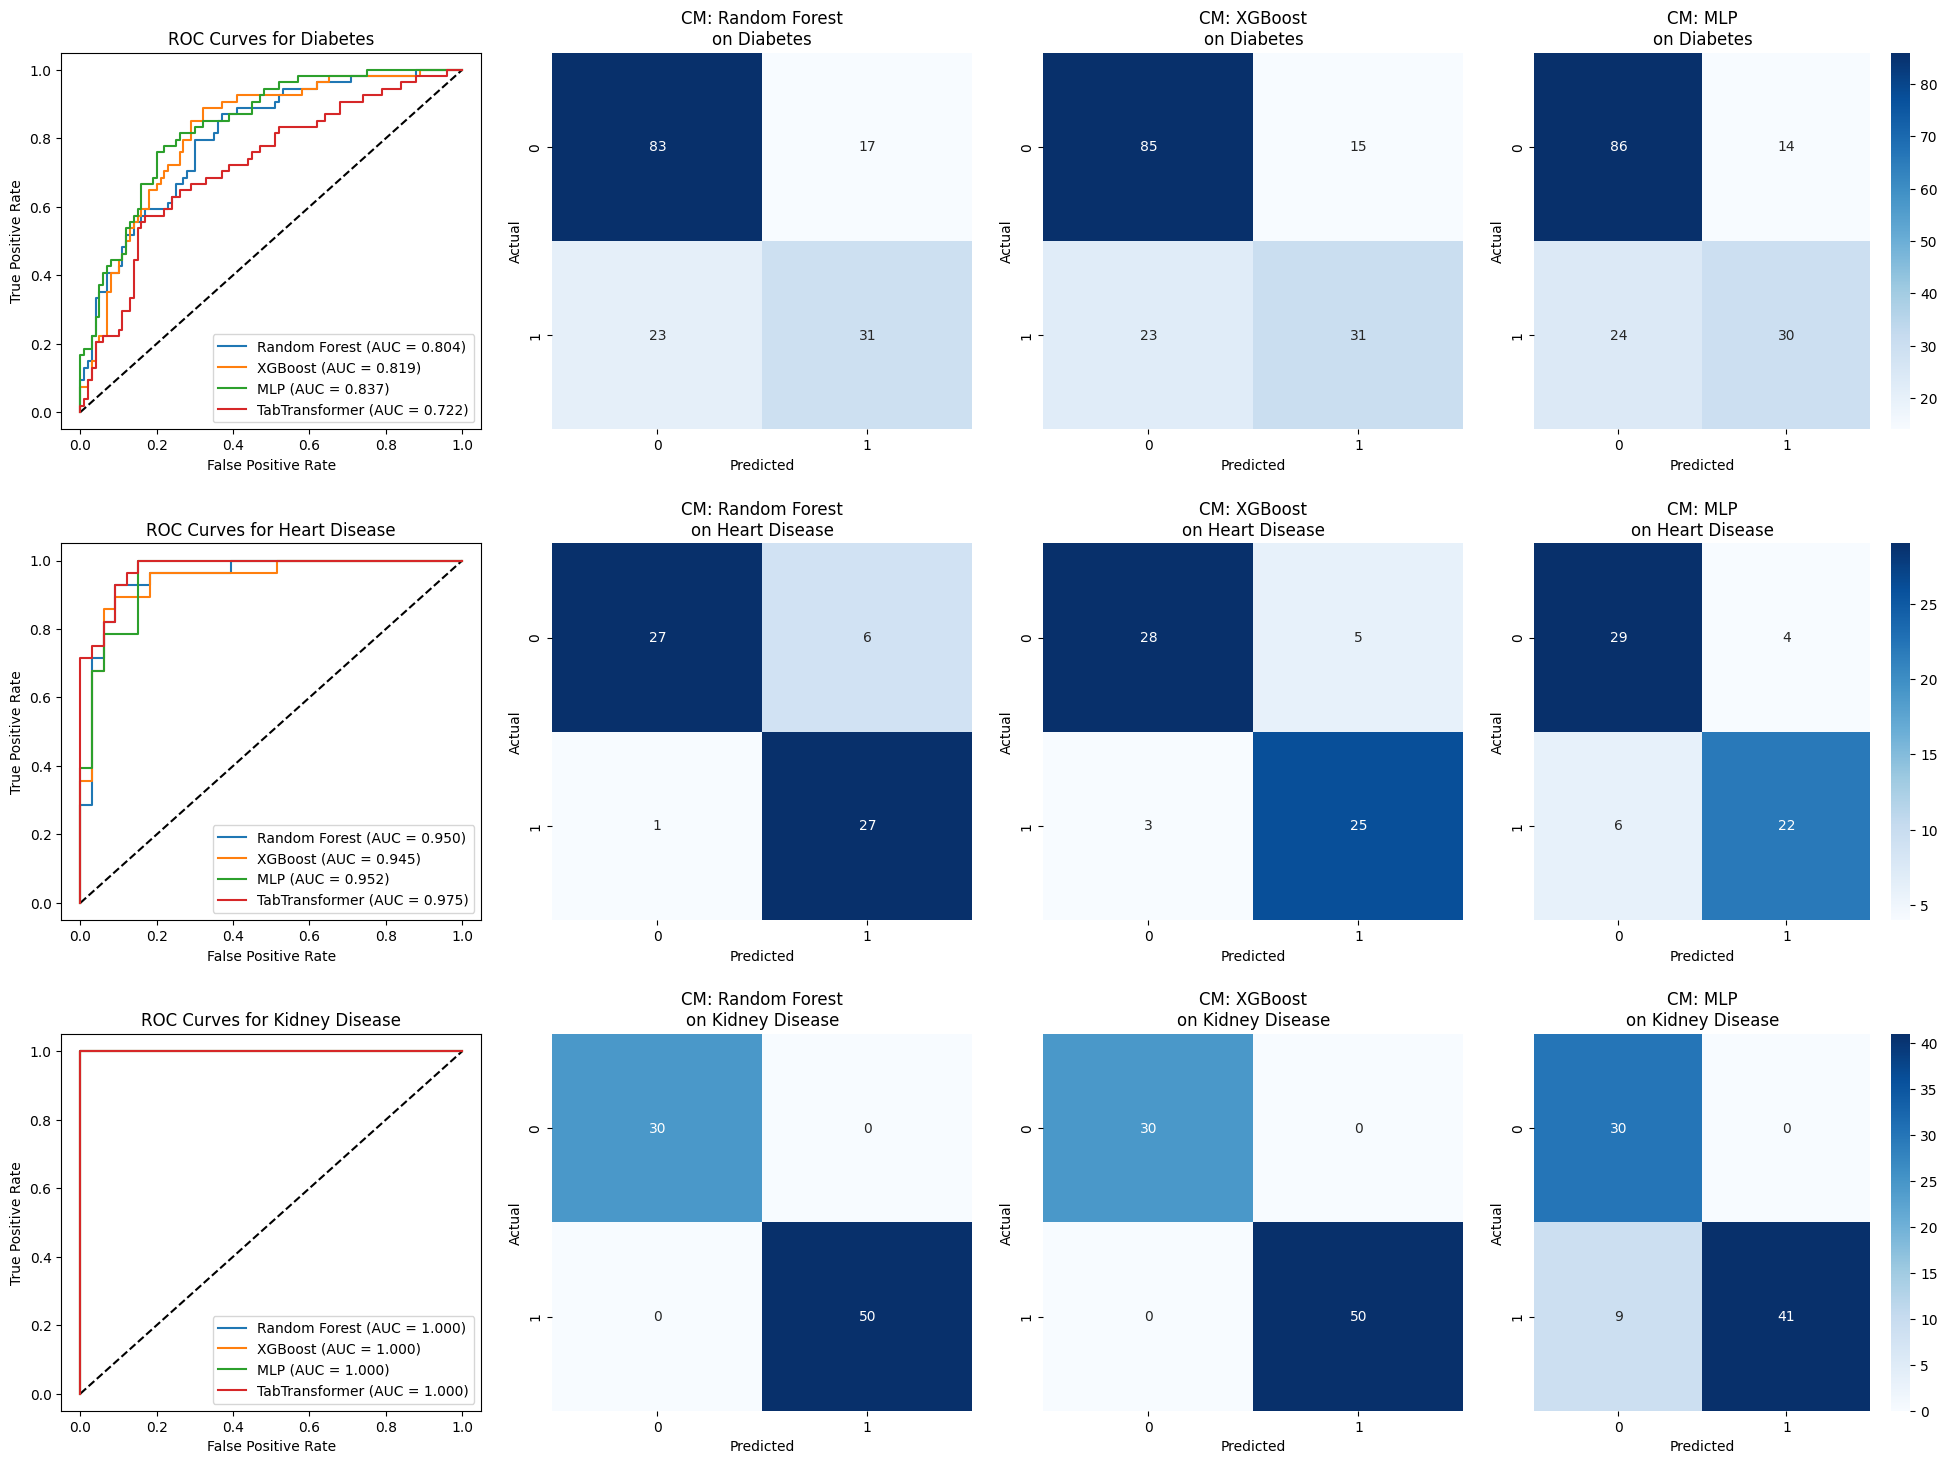

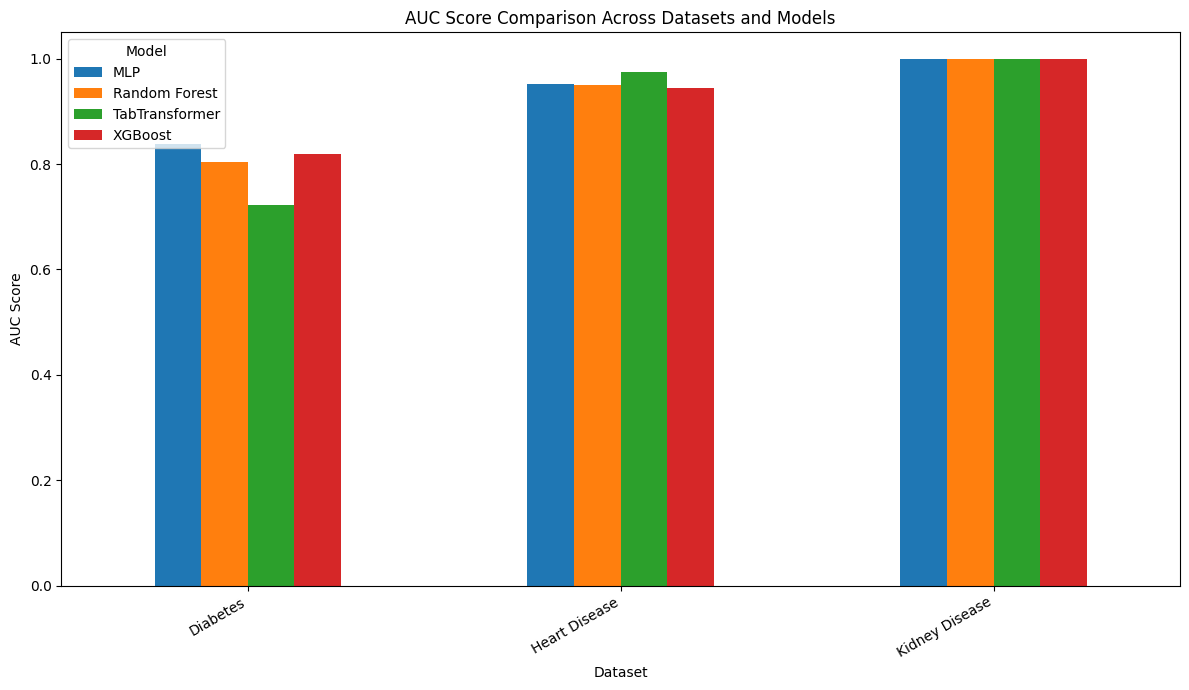

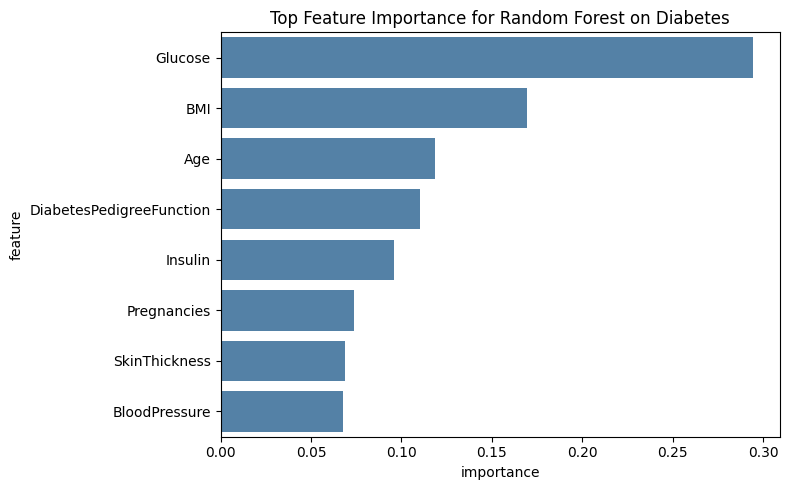

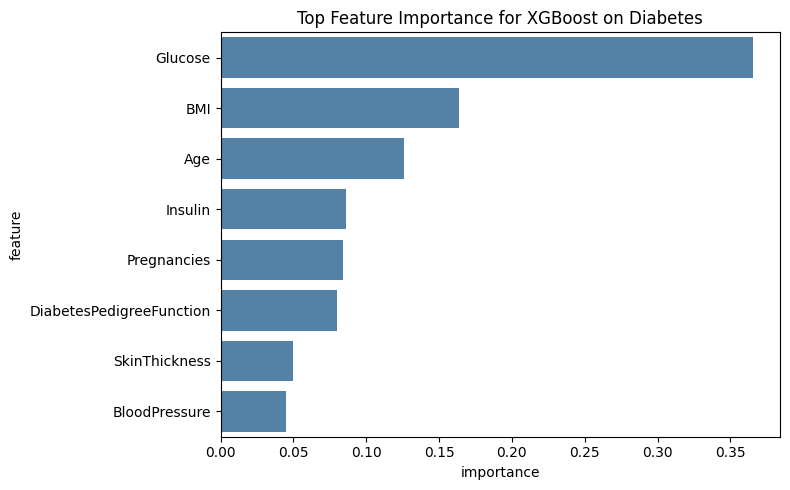

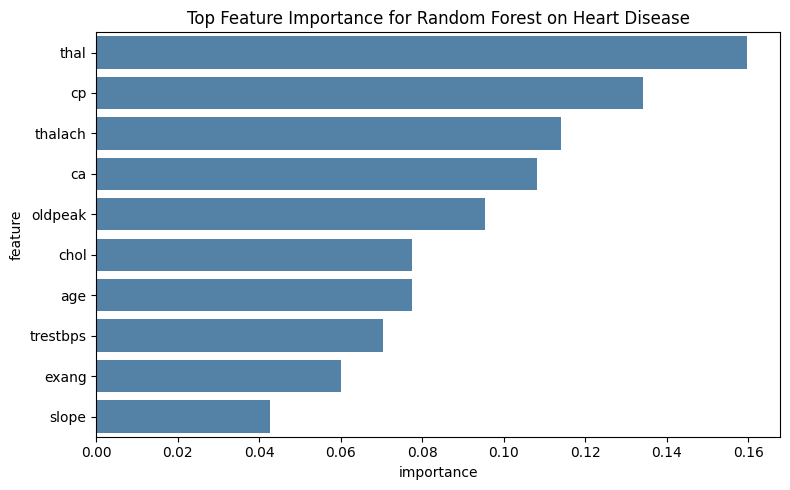

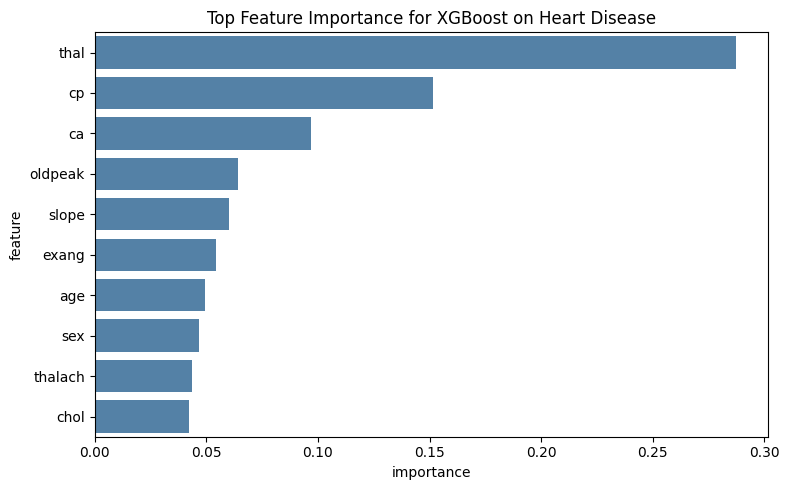

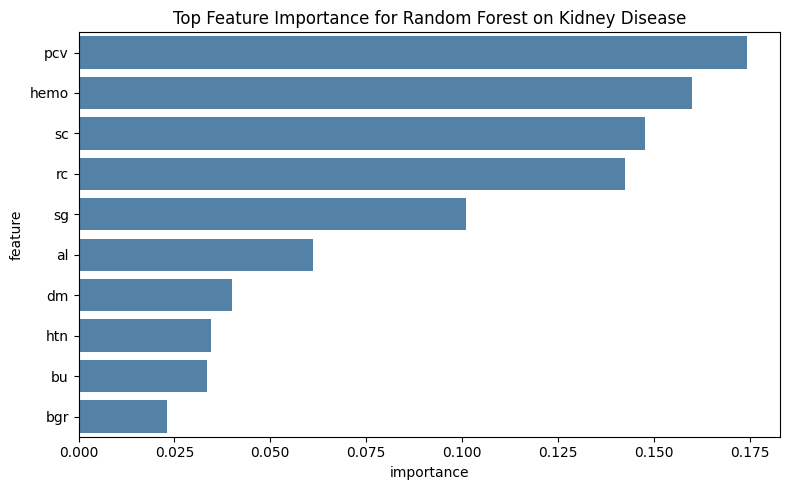

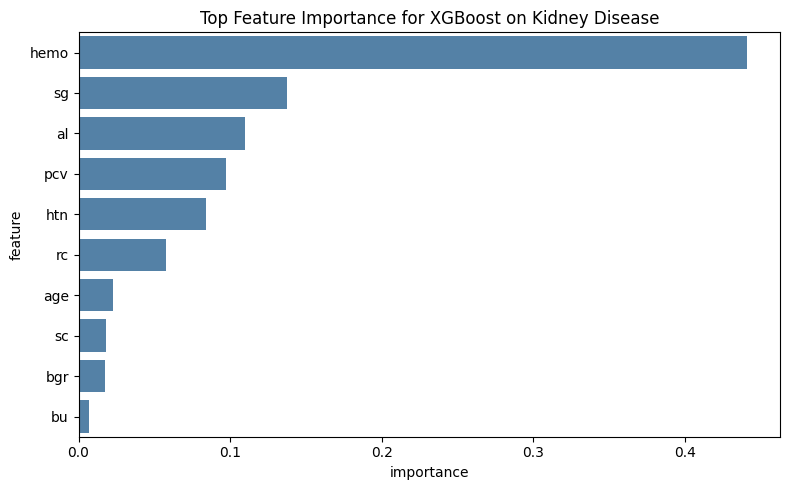

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization, Input, Embedding,
                                     MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D,
                                     Concatenate, Add, Reshape) # Added Reshape, Add
from tensorflow.keras.callbacks import EarlyStopping
# from scikeras.wrappers import KerasClassifier # Not strictly needed for manual MLP/Transformer tuning

# Other ML Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- 1. DATA LOADING & INITIAL CLEANING ---

# 1.1 Diabetes Dataset
print("--- Loading Diabetes Data ---")
df_diabetes = pd.read_csv('/content/diabetes.csv')
cols_to_replace_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_diabetes[cols_to_replace_zero] = df_diabetes[cols_to_replace_zero].replace(0, np.nan)
X_diabetes = df_diabetes.drop('Outcome', axis=1)
y_diabetes = df_diabetes['Outcome']
print(f"Diabetes data loaded: X_shape={X_diabetes.shape}, y_shape={y_diabetes.shape}\n")

# 1.2 Heart Disease Dataset
print("--- Loading Heart Disease Data ---")
df_heart = pd.read_csv('/content/Heart_disease.csv')
df_heart.columns = df_heart.columns.str.strip() # Remove leading/trailing whitespace (like BOM)
if 'Unnamed: 0' in df_heart.columns: df_heart = df_heart.drop('Unnamed: 0', axis=1)
for col in df_heart.columns:
    if df_heart[col].dtype == 'object':
        df_heart[col] = pd.to_numeric(df_heart[col].replace('?', np.nan), errors='coerce')
X_heart = df_heart.drop('target', axis=1)
y_heart = df_heart['target']
print(f"Heart Disease data loaded: X_shape={X_heart.shape}, y_shape={y_heart.shape}\n")

# 1.3 Kidney Disease Dataset
print("--- Loading and Cleaning Kidney Disease Data ---")
df_kidney_original = pd.read_csv('/content/kidney_disease.csv')
df_kidney = df_kidney_original.copy()

if 'id' in df_kidney.columns:
    df_kidney = df_kidney.drop('id', axis=1)
df_kidney.columns = [col.lower().strip() for col in df_kidney.columns]
df_kidney = df_kidney.replace(['?', '\t?', '', ' ', '\t'], np.nan) # More comprehensive NaN replacement
for col in df_kidney.columns:
    if df_kidney[col].dtype == 'object':
        df_kidney[col] = df_kidney[col].str.strip()

TARGET_COL_KIDNEY = 'classification'
df_kidney[TARGET_COL_KIDNEY] = df_kidney[TARGET_COL_KIDNEY].replace({'ckd': 1, 'notckd': 0})

binary_map = {'normal': 0, 'abnormal': 1}
if 'rbc' in df_kidney.columns: df_kidney['rbc'] = df_kidney['rbc'].replace(binary_map)
if 'pc' in df_kidney.columns: df_kidney['pc'] = df_kidney['pc'].replace(binary_map)

binary_map_present = {'present': 1, 'notpresent': 0}
if 'pcc' in df_kidney.columns: df_kidney['pcc'] = df_kidney['pcc'].replace(binary_map_present)
if 'ba' in df_kidney.columns: df_kidney['ba'] = df_kidney['ba'].replace(binary_map_present)

binary_map_yes_no = {'yes': 1, 'no': 0}
if 'htn' in df_kidney.columns: df_kidney['htn'] = df_kidney['htn'].replace(binary_map_yes_no)
if 'dm' in df_kidney.columns:
    df_kidney['dm'] = df_kidney['dm'].replace({'\tyes': 'yes', ' yes': 'yes', '\tno':'no'})
    df_kidney['dm'] = df_kidney['dm'].replace(binary_map_yes_no)
if 'cad' in df_kidney.columns: df_kidney['cad'] = df_kidney['cad'].replace(binary_map_yes_no)
if 'pe' in df_kidney.columns: df_kidney['pe'] = df_kidney['pe'].replace(binary_map_yes_no)
if 'ane' in df_kidney.columns: df_kidney['ane'] = df_kidney['ane'].replace(binary_map_yes_no)
if 'appet' in df_kidney.columns: df_kidney['appet'] = df_kidney['appet'].replace({'good': 0, 'poor': 1})

for col in df_kidney.columns:
    df_kidney[col] = pd.to_numeric(df_kidney[col], errors='coerce')

df_kidney.dropna(subset=[TARGET_COL_KIDNEY], inplace=True)
y_kidney = df_kidney[TARGET_COL_KIDNEY].astype(int)
X_kidney = df_kidney.drop(TARGET_COL_KIDNEY, axis=1)
print(f"Kidney Disease data loaded and cleaned: X_shape={X_kidney.shape}, y_shape={y_kidney.shape}\n")


# --- 2. PREPROCESSING PIPELINE & DATA STORAGE ---
datasets_raw = {
    'Diabetes': (X_diabetes, y_diabetes),
    'Heart Disease': (X_heart, y_heart),
    'Kidney Disease': (X_kidney, y_kidney)
}

processed_datasets = {}
categorical_features_metadata_all = {} # Store metadata for Transformer

for name, (X_raw, y_raw) in datasets_raw.items():
    print(f"--- Preprocessing {name} ---")
    X_processed = X_raw.copy()
    y = y_raw.copy()

    # Define categorical and numerical columns for THIS dataset
    if name == 'Diabetes':
        num_cols = X_processed.columns.tolist()
        cat_cols = []
    elif name == 'Heart Disease':
        potential_cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        cat_cols = [col for col in potential_cat_cols if col in X_processed.columns]
        num_cols = [col for col in X_processed.columns if col not in cat_cols]
    elif name == 'Kidney Disease':
        # Based on typical understanding of CKD dataset after initial numeric conversion
        base_numerical_kidney = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
        base_categorical_kidney = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
        num_cols = [col for col in base_numerical_kidney if col in X_processed.columns]
        cat_cols = [col for col in base_categorical_kidney if col in X_processed.columns]
    else: # Fallback (should not happen with these three datasets)
        num_cols = X_processed.select_dtypes(include=np.number).columns.tolist()
        cat_cols = X_processed.select_dtypes(exclude=np.number).columns.tolist()

    print(f"Identified Numerical cols for {name}: {num_cols}")
    print(f"Identified Categorical cols for {name}: {cat_cols}")

    # Impute numerical columns
    if num_cols:
        median_imputer = SimpleImputer(strategy='median')
        X_processed[num_cols] = median_imputer.fit_transform(X_processed[num_cols])

    # Impute and Label Encode categorical columns for general use and Transformer
    dataset_cat_meta = []
    if cat_cols:
        mode_imputer_cat = SimpleImputer(strategy='most_frequent')
        for col in cat_cols:
            X_processed[col] = mode_imputer_cat.fit_transform(X_processed[[col]]).ravel() # Impute first
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col]) # Then Label Encode
            num_unique = X_processed[col].nunique()
            embed_dim = min(10, (num_unique + 1) // 2) # Simple heuristic for embedding dim
            dataset_cat_meta.append({'name': col, 'num_categories': num_unique, 'embedding_dim': embed_dim})
    categorical_features_metadata_all[name] = dataset_cat_meta

    # Data for MLP, RF, XGBoost (all features scaled)
    scaler_std = StandardScaler()
    X_scaled_vals = scaler_std.fit_transform(X_processed) # X_processed now contains label-encoded categoricals
    X_scaled_df = pd.DataFrame(X_scaled_vals, columns=X_processed.columns, index=X_processed.index)

    # Data for TabTransformer
    # Numerical features scaled, categorical features are label-encoded (from X_processed)
    X_transformer_ready = X_processed.copy()
    if num_cols: # Scale numerical part again, just to be safe it's using fresh scaler on potentially imputed data
        scaler_tt_num = StandardScaler()
        X_transformer_ready[num_cols] = scaler_tt_num.fit_transform(X_transformer_ready[num_cols])

    # Split
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
        X_scaled_df, y, test_size=0.2, random_state=SEED, stratify=y
    )
    X_train_transformer, X_test_transformer, _, _ = train_test_split(
        X_transformer_ready, y, test_size=0.2, random_state=SEED, stratify=y
    ) # y_train, y_test are the same

    processed_datasets[name] = {
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_test': y_test,
        'X_train_transformer_df': X_train_transformer, # DataFrame version
        'X_test_transformer_df': X_test_transformer,   # DataFrame version
        'feature_names': X_processed.columns.tolist(),
        'num_cols_for_transformer': num_cols,
        'cat_cols_for_transformer': cat_cols
    }
    print(f"{name} preprocessed. Train shape: {X_train_scaled.shape}\n")


# --- 3. MODEL DEFINITIONS ---

# 3.1 MLP
def create_mlp_model(input_dim, optimizer='adam', dropout_rate=0.2, neurons=64):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons * 2, activation='relu'), BatchNormalization(), Dropout(dropout_rate),
        Dense(neurons, activation='relu'), BatchNormalization(), Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# 3.2 Tabular Transformer (Simplified)
# --- Simplified Tabular Transformer Model (Corrected Logic for Empty Lists) ---
def create_tab_transformer_model(
    numerical_feature_names, # list of names
    categorical_features_info, # list of dicts: [{'name':str, 'num_categories':int, 'embedding_dim':int}, ...]
    transformer_blocks=1, num_heads=2, ff_dim_transformer=32, projection_dim=16, mlp_hidden_units=[64,32], dropout_rate=0.1, mlp_dropout=0.2
    ):

    inputs_list = []
    processed_features_for_concat = [] # List to hold processed numerical and categorical blocks

    # Numerical features
    if numerical_feature_names:
        numerical_input_layer = Input(shape=(len(numerical_feature_names),), name='numerical_input')
        inputs_list.append(numerical_input_layer)
        x_numeric = LayerNormalization(epsilon=1e-6)(numerical_input_layer)
        x_numeric_projected = Dense(projection_dim, name='numeric_projection')(x_numeric) # Project to common dim
        # For concatenation later, it's often good if numerical features are also "token-like"
        # or handled as a single block.
        # If we treat the entire block of projected numericals as one "token" for the MLP head:
        processed_features_for_concat.append(x_numeric_projected)

    # Categorical features
    if categorical_features_info:
        embedded_categoricals_list_for_stacking = []
        for cat_info in categorical_features_info:
            cat_input = Input(shape=(1,), name=f'cat_input_{cat_info["name"]}')
            inputs_list.append(cat_input)
            # Ensure input_dim is correct (max_index + 1)
            # If LabelEncoder gives 0 to N-1, then num_categories is N, so input_dim=N
            embedding = Embedding(
                input_dim=cat_info['num_categories'],
                output_dim=projection_dim, # Use common projection_dim
                name=f'embed_{cat_info["name"]}'
            )(cat_input)
            # embedding output shape: (batch_size, 1, projection_dim)
            embedded_categoricals_list_for_stacking.append(embedding) # Keep the (batch, 1, dim) shape

        if embedded_categoricals_list_for_stacking:
            # Concatenate along the "sequence" dimension (which represents different cat features)
            # Resulting shape: (batch_size, num_categorical_features, projection_dim)
            categorical_tokens = Concatenate(axis=1)(embedded_categoricals_list_for_stacking)

            x_cat = categorical_tokens
            for _ in range(transformer_blocks):
                att_output = MultiHeadAttention(
                    num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
                )(x_cat, x_cat) # Self-attention among categorical features
                x_cat = Add()([x_cat, att_output])
                x_cat = LayerNormalization(epsilon=1e-6)(x_cat)

                ffn = Sequential([Dense(ff_dim_transformer, activation="relu"), Dense(projection_dim)], name=f'ffn_block_{_}')
                ffn_output = ffn(x_cat)
                x_cat = Add()([x_cat, ffn_output])
                x_cat = LayerNormalization(epsilon=1e-6)(x_cat)

            processed_categorical = GlobalAveragePooling1D(name='gap_categorical')(x_cat) # Pool to (batch_size, projection_dim)
            processed_features_for_concat.append(processed_categorical)

    # Check if any features were processed
    if not processed_features_for_concat:
        raise ValueError("No features (neither numerical nor categorical) were processed for the model.")

    # Concatenate all processed feature blocks
    if len(processed_features_for_concat) > 1:
        combined_features = Concatenate(name='combine_all_features')(processed_features_for_concat)
    else:
        combined_features = processed_features_for_concat[0] # Only one block (either all numerical or all categorical)

    # MLP Head
    x = combined_features
    for i, units in enumerate(mlp_hidden_units):
        x = Dense(units, activation="relu", name=f'mlp_head_dense_{i}')(x)
        x = Dropout(mlp_dropout, name=f'mlp_head_dropout_{i}')(x)

    output_layer = Dense(1, activation="sigmoid", name='output_sigmoid')(x)

    if not inputs_list: # Should not happen if the above ValueError is raised correctly
        raise ValueError("Model has no inputs defined. Check feature processing.")

    model = Model(inputs=inputs_list, outputs=output_layer)
    # Using AdamW is often good for transformers, can also use 'adam'
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name='auc')])
    return model

# Helper to prepare input for Keras multi-input model
def prepare_transformer_input_list(df_X_transformer, num_col_names, cat_col_names_ordered):
    input_data_list = []
    if num_col_names: # Numerical features first, if they exist
        input_data_list.append(df_X_transformer[num_col_names].values.astype(np.float32))
    for col_name in cat_col_names_ordered: # Then categorical, in defined order
        input_data_list.append(df_X_transformer[col_name].values.astype(np.int32).reshape(-1,1))
    return input_data_list


# --- 4. HYPERPARAMETER GRIDS ---
param_grid_rf = {'n_estimators': [100, 150], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
param_grid_xgb = {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
param_grid_mlp_manual = {'optimizer': ['adam', 'rmsprop'], 'dropout_rate': [0.2, 0.3], 'neurons': [32, 64], 'batch_size': [32], 'epochs': [50]}
param_grid_tab_transformer_manual = {
    'transformer_blocks': [1,2], 'num_heads': [2], 'projection_dim': [16, 32],
    'ff_dim_transformer': [32], 'mlp_hidden_units': [[32,16],[64,32]], 'dropout_rate': [0.1], 'mlp_dropout':[0.1],
    'batch_size': [32], 'epochs': [25, 50] # Reduced for speed
}

# --- 5. TRAINING, TUNING, EVALUATION ---
results_list = []
best_estimators = {}
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

for name, data_dict in processed_datasets.items():
    X_train_s = data_dict['X_train_scaled']
    X_test_s = data_dict['X_test_scaled']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']

    X_train_t_df = data_dict['X_train_transformer_df']
    X_test_t_df = data_dict['X_test_transformer_df']

    feature_names = data_dict['feature_names']
    cat_meta_for_ds = categorical_features_metadata_all[name] # list of dicts for this dataset
    num_cols_list_for_ds = data_dict['num_cols_for_transformer'] # list of num col names
    cat_cols_list_for_ds = data_dict['cat_cols_for_transformer'] # list of cat col names (order matters for input)


    print(f"\n--- Evaluating Models for {name} ---")
    best_estimators[name] = {}
    y_train_np = np.array(y_train)
    y_test_np = np.array(y_test)

    # Models using scaled data (RF, XGB, MLP)
    models_sklearn = {
        'Random Forest': (RandomForestClassifier(random_state=SEED), param_grid_rf),
        'XGBoost': (XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
    }
    for model_name, (model_instance, params) in models_sklearn.items():
        print(f"Tuning {model_name} for {name}...")
        grid_search = GridSearchCV(estimator=model_instance, param_grid=params, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=0)
        grid_search.fit(X_train_s, y_train)
        best_model = grid_search.best_estimator_
        best_estimators[name][model_name] = best_model
        y_pred = best_model.predict(X_test_s)
        y_pred_proba = best_model.predict_proba(X_test_s)[:, 1]
        results_list.append({'Dataset': name, 'Model': model_name, 'Accuracy': accuracy_score(y_test, y_pred),
                             'Precision': precision_score(y_test, y_pred, zero_division=0), 'Recall': recall_score(y_test, y_pred, zero_division=0),
                             'F1 Score': f1_score(y_test, y_pred, zero_division=0), 'AUC': roc_auc_score(y_test, y_pred_proba)})
        print(f"Best params for {model_name}: {grid_search.best_params_}, Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # MLP - Manual Tuning
    print(f"Tuning MLP for {name}...")
    best_mlp_auc = -1; best_mlp_model = None; best_mlp_params = {}
    for opt in param_grid_mlp_manual['optimizer']:
        for dr in param_grid_mlp_manual['dropout_rate']:
            for nr in param_grid_mlp_manual['neurons']:
                bs = param_grid_mlp_manual['batch_size'][0]; eps = param_grid_mlp_manual['epochs'][0]
                mlp = create_mlp_model(X_train_s.shape[1], optimizer=opt, dropout_rate=dr, neurons=nr)
                es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=0)
                mlp.fit(X_train_s, y_train_np, epochs=eps, batch_size=bs, validation_split=0.2, callbacks=[es], verbose=0)
                y_pred_proba_mlp = mlp.predict(X_test_s, verbose=0).ravel()
                auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
                if auc_mlp > best_mlp_auc:
                    best_mlp_auc = auc_mlp; best_mlp_model = mlp; best_mlp_params = {'optimizer':opt, 'dropout_rate':dr, 'neurons':nr, 'batch_size':bs, 'epochs':eps}
    best_estimators[name]['MLP'] = best_mlp_model
    if best_mlp_model:
        y_pred_proba_mlp = best_mlp_model.predict(X_test_s, verbose=0).ravel()
        y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)
        results_list.append({'Dataset': name, 'Model': 'MLP', 'Accuracy': accuracy_score(y_test, y_pred_mlp),
                             'Precision': precision_score(y_test, y_pred_mlp, zero_division=0), 'Recall': recall_score(y_test, y_pred_mlp, zero_division=0),
                             'F1 Score': f1_score(y_test, y_pred_mlp, zero_division=0), 'AUC': roc_auc_score(y_test, y_pred_proba_mlp)})
        print(f"Best params for MLP: {best_mlp_params}, Test AUC: {roc_auc_score(y_test, y_pred_proba_mlp):.4f}")


    # TabTransformer - Manual Tuning
    print(f"Tuning TabTransformer for {name}...")
    # Prepare ordered list of categorical feature names for consistent input creation
    ordered_cat_feature_names_for_transformer = [info['name'] for info in cat_meta_for_ds]

    X_train_tt_input_list = prepare_transformer_input_list(X_train_t_df, num_cols_list_for_ds, ordered_cat_feature_names_for_transformer)
    X_test_tt_input_list = prepare_transformer_input_list(X_test_t_df, num_cols_list_for_ds, ordered_cat_feature_names_for_transformer)

    best_tt_auc = -1; best_tt_model = None; best_tt_params = {}
    for tb in param_grid_tab_transformer_manual['transformer_blocks']:
      for nh in param_grid_tab_transformer_manual['num_heads']:
        for pdim in param_grid_tab_transformer_manual['projection_dim']:
            # Simplified loop for brevity
            ffd_t = param_grid_tab_transformer_manual['ff_dim_transformer'][0]
            mlp_hu = param_grid_tab_transformer_manual['mlp_hidden_units'][0]
            dr_t = param_grid_tab_transformer_manual['dropout_rate'][0]
            mlp_dr = param_grid_tab_transformer_manual['mlp_dropout'][0]
            bs = param_grid_tab_transformer_manual['batch_size'][0]
            eps = param_grid_tab_transformer_manual['epochs'][0]

            tt_model = create_tab_transformer_model(
                numerical_feature_names=num_cols_list_for_ds,
                categorical_features_info=cat_meta_for_ds,
                transformer_blocks=tb, num_heads=nh, projection_dim=pdim,
                ff_dim_transformer=ffd_t, mlp_hidden_units=mlp_hu,
                dropout_rate=dr_t, mlp_dropout=mlp_dr
            )
            es_tt = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=0) # Reduced patience

            # Use a fraction of test data as validation for TT tuning during this manual loop for speed
            # This is not ideal but practical for a quick run. Proper way: split train into train/val.
            tt_model.fit(X_train_tt_input_list, y_train_np, epochs=eps, batch_size=bs,
                         validation_data=(X_test_tt_input_list, y_test_np),
                         callbacks=[es_tt], verbose=0)

            y_pred_proba_tt = tt_model.predict(X_test_tt_input_list, verbose=0).ravel()
            auc_tt = roc_auc_score(y_test, y_pred_proba_tt)
            if auc_tt > best_tt_auc:
                best_tt_auc = auc_tt; best_tt_model = tt_model;
                best_tt_params = {'blocks':tb, 'heads':nh, 'proj_dim':pdim, 'ff_dim':ffd_t, 'mlp_units':mlp_hu,
                                  'dr_trans':dr_t, 'dr_mlp':mlp_dr, 'batch':bs, 'epochs':eps}

    best_estimators[name]['TabTransformer'] = best_tt_model
    if best_tt_model:
        y_pred_proba_tt = best_tt_model.predict(X_test_tt_input_list, verbose=0).ravel()
        y_pred_tt = (y_pred_proba_tt > 0.5).astype(int)
        results_list.append({'Dataset': name, 'Model': 'TabTransformer', 'Accuracy': accuracy_score(y_test, y_pred_tt),
                             'Precision': precision_score(y_test, y_pred_tt, zero_division=0), 'Recall': recall_score(y_test, y_pred_tt, zero_division=0),
                             'F1 Score': f1_score(y_test, y_pred_tt, zero_division=0), 'AUC': roc_auc_score(y_test, y_pred_proba_tt)})
        print(f"Best params for TabTransformer: {best_tt_params}, Test AUC: {roc_auc_score(y_test, y_pred_proba_tt):.4f}")

results_df = pd.DataFrame(results_list)
print("\n--- Overall Results ---")
print(results_df)


# --- 6. VISUALIZATIONS ---
# ROC Curves
num_datasets = len(processed_datasets)
num_models_per_plot = 4 # RF, XGB, MLP, TabTransformer
fig_roc_cm, axes_roc_cm = plt.subplots(num_datasets, num_models_per_plot, figsize=(5 * num_models_per_plot, 5 * num_datasets))
if num_datasets == 1: axes_roc_cm = np.array([axes_roc_cm]) # Ensure it's 2D for consistent indexing

plot_row = 0
for name, data_dict in processed_datasets.items():
    y_test_plot = data_dict['y_test']

    # ROC Curve for the dataset (first column of this row)
    ax_roc = axes_roc_cm[plot_row, 0]
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Curves for {name}')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')

    model_plot_col_idx = 1 # Start CMs from the second column

    for model_name, model_instance in best_estimators[name].items():
        if model_instance is not None:
            y_pred_proba_plot = None
            y_pred_plot = None

            if model_name in ['Random Forest', 'XGBoost']:
                y_pred_proba_plot = model_instance.predict_proba(data_dict['X_test_scaled'])[:, 1]
                y_pred_plot = model_instance.predict(data_dict['X_test_scaled'])
            elif model_name == 'MLP':
                y_pred_proba_plot = model_instance.predict(data_dict['X_test_scaled'], verbose=0).ravel()
                y_pred_plot = (y_pred_proba_plot > 0.5).astype(int)
            elif model_name == 'TabTransformer':
                current_cat_meta = categorical_features_metadata_all[name]
                num_cols_list = data_dict['num_cols_for_transformer']
                cat_cols_list_ordered = [info['name'] for info in current_cat_meta]

                X_test_tt_input_list_viz = prepare_transformer_input_list(
                    data_dict['X_test_transformer_df'],
                    num_cols_list,
                    cat_cols_list_ordered
                )
                y_pred_proba_plot = model_instance.predict(X_test_tt_input_list_viz, verbose=0).ravel()
                y_pred_plot = (y_pred_proba_plot > 0.5).astype(int)

            # Plot on shared ROC axis
            fpr, tpr, _ = roc_curve(y_test_plot, y_pred_proba_plot)
            auc_val = roc_auc_score(y_test_plot, y_pred_proba_plot)
            ax_roc.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_val:.3f})')

            # Plot Confusion Matrix
            if model_plot_col_idx < num_models_per_plot : # Should always be true if setup correctly
                ax_cm = axes_roc_cm[plot_row, model_plot_col_idx]
                cm = confusion_matrix(y_test_plot, y_pred_plot)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm, cbar=model_plot_col_idx==num_models_per_plot-1) # Cbar only on last CM
                ax_cm.set_title(f'CM: {model_name}\non {name}')
                ax_cm.set_xlabel('Predicted')
                ax_cm.set_ylabel('Actual')
                model_plot_col_idx += 1

    ax_roc.legend()
    plot_row += 1

plt.tight_layout(pad=2.0)
plt.show()


# AUC Comparison Bar Chart
if not results_df.empty:
    auc_results = results_df.pivot(index='Dataset', columns='Model', values='AUC')
    auc_results.plot(kind='bar', figsize=(12, 7))
    plt.title('AUC Score Comparison Across Datasets and Models')
    plt.ylabel('AUC Score')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
else:
    print("Results DataFrame is empty, skipping AUC bar chart.")


# Feature Importance (for tree-based models)
for name, data_dict in processed_datasets.items():
    feature_names_fi = data_dict['feature_names']
    for model_name in ['Random Forest', 'XGBoost']:
        if model_name in best_estimators[name] and best_estimators[name][model_name] is not None:
            model_instance = best_estimators[name][model_name]
            if hasattr(model_instance, 'feature_importances_'):
                importances = model_instance.feature_importances_
                feature_importance_df = pd.DataFrame({'feature': feature_names_fi, 'importance': importances})
                feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10) # Top 10

                plt.figure(figsize=(8, 5))
                sns.barplot(x='importance', y='feature', data=feature_importance_df, color='steelblue')
                plt.title(f'Top Feature Importance for {model_name} on {name}')
                plt.tight_layout()
                plt.show()